## Using SHAP for interpretability

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np


from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from ngboost import NGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import pickle
import shap
shap.initjs()

In [7]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((889, 22), (381, 22))

In [9]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
X_train_knn_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [11]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [12]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((889, 22), (381, 22))

In [13]:
sel = ['Gender', 'MMSE', 'Hip Correlation', 'Hip Variance ',
       'Hip Sum Variance', 'Hip Entropy', 'ERC ASM', 'ERC VARIANCE ',
       'ERC ENTROPY', 'ERC CLUSTER SHADE', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'TOTAL_HIPPOCAMPUS_VOLUME']

In [14]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Gender',
 'MMSE',
 'Hip Correlation',
 'Hip Variance ',
 'Hip Sum Variance',
 'Hip Entropy',
 'ERC ASM',
 'ERC VARIANCE ',
 'ERC ENTROPY',
 'ERC CLUSTER SHADE',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [15]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((889, 13), (381, 13))

In [16]:
with open("rf_model.pkl", "rb") as file:
    loaded_model_rf = pickle.load(file)
print(f"{loaded_model_rf} model loaded successfully!\n")

with open("xgboost_model.pkl", "rb") as file:
    loaded_model_xgb = pickle.load(file)
print(f"{loaded_model_xgb} model loaded successfully!\n")


with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)
print(f"{loaded_model_ngb} model loaded successfully!")

with open("logit_model.pkl", "rb") as file:
    loaded_model_logit = pickle.load(file)
print(f"{loaded_model_logit} model loaded successfully!")

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features='log2',
                       min_samples_leaf=0.001982936158318523,
                       min_samples_split=0.044740233953342756, n_estimators=232,
                       random_state=42) model loaded successfully!

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6555070145875974, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.42459966427637585,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.024222784557934973,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=4, missing=nan, monotone

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_t)
X_test_s = scaler.transform(X_test_t)

In [18]:
# Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(loaded_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_t)

In [19]:
# Compute SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(loaded_model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

In [20]:
# Compute SHAP values for NGBoost
explainer_ngb = shap.Explainer(loaded_model_ngb.predict_proba, X_test_t)
shap_values_ngb = explainer_ngb(X_test_t)


PermutationExplainer explainer: 382it [57:33,  9.06s/it]                           


In [21]:
# Compute SHAP values for Logistic Regression
explainer_logit = shap.LinearExplainer(loaded_model_logit, X_test_s)
shap_values_logit = explainer_logit.shap_values(X_test_s)

In [22]:
print(shap_values_rf.shape)
print(shap_values_xgb.shape)
print(shap_values_ngb.shape)
print(shap_values_logit.shape)

(381, 13, 3)
(381, 13, 3)
(381, 13, 3)
(381, 13, 3)


## Global interpretability

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\804790303.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


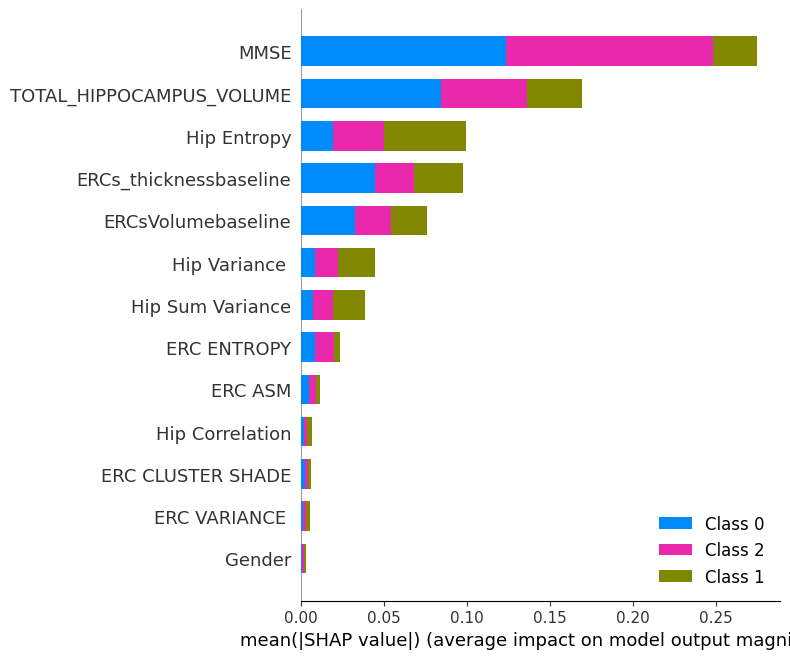

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\804790303.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


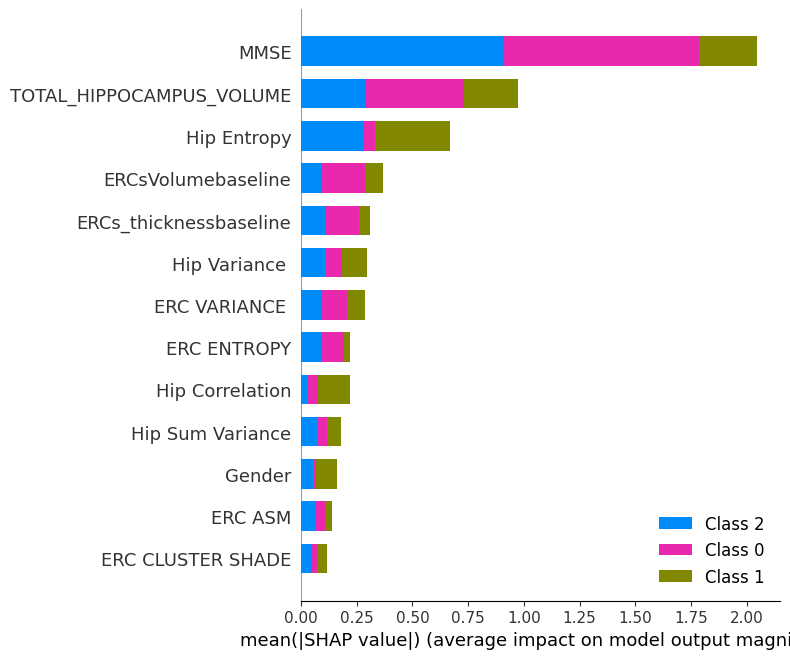

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\804790303.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


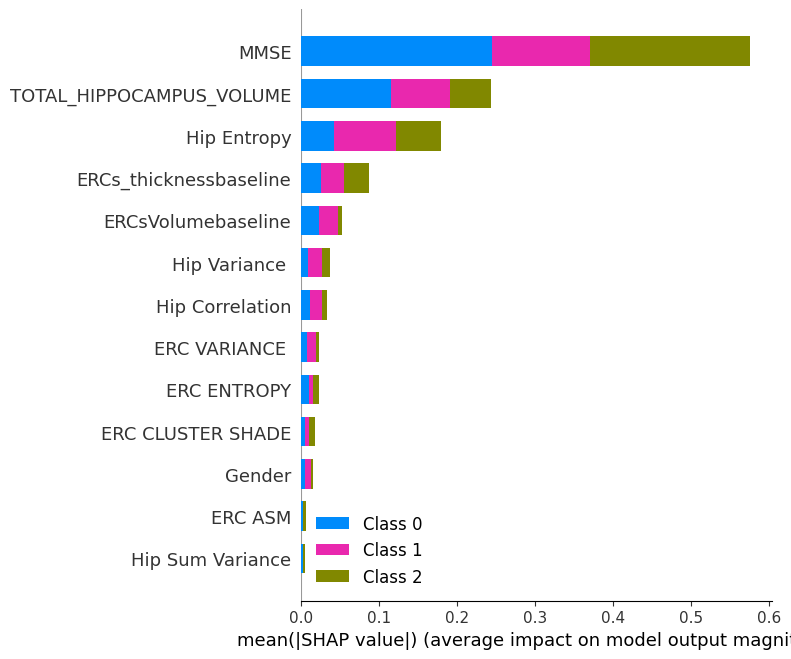

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\804790303.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


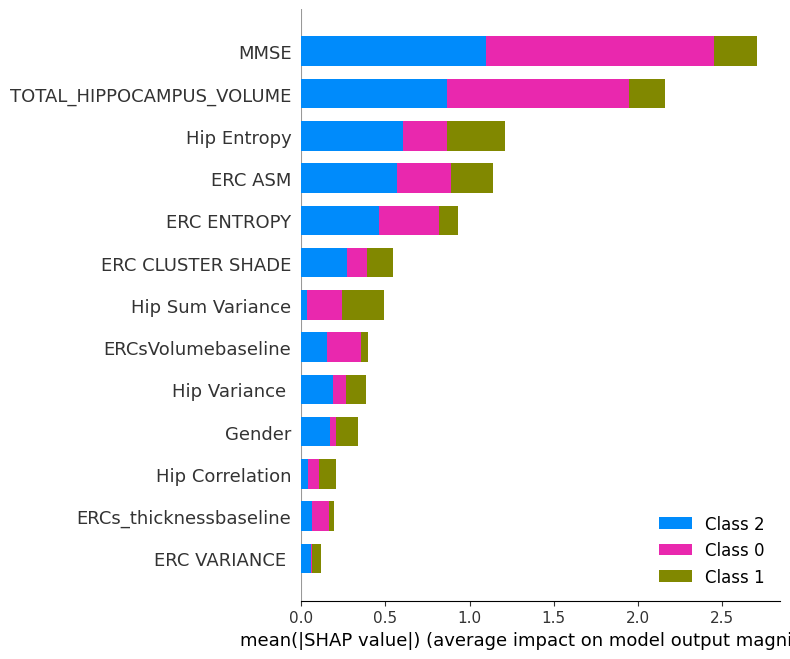

In [23]:
# Beeswarm plots
shap.summary_plot(shap_values_rf, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_ngb.values, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_logit, X_test_t, feature_names=X_test_t.columns, plot_type="bar")

## Local interpretability

In [24]:
## SHAP plot for loc trees
explainer_rf = shap.TreeExplainer(loaded_model_rf) 
shap_values_rf = explainer_rf.shap_values(X_test_t)

print(shap_values_rf.shape)
print(explainer_rf.expected_value)

(381, 13, 3)
[0.33319611 0.33190361 0.33490028]


In [25]:
# Force plot for the first instance
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0, :, 1], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

SHAP Beeswarm Plot for Class 0


C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


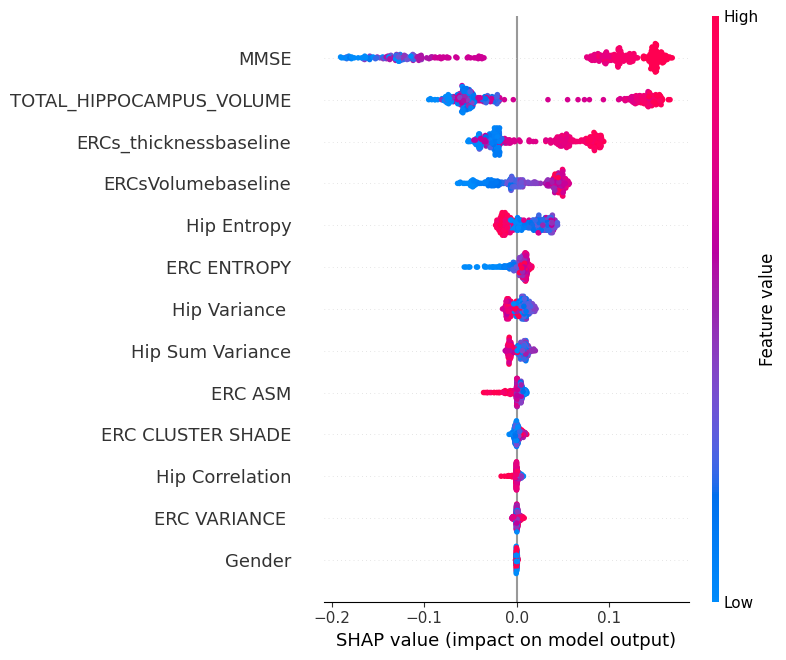

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


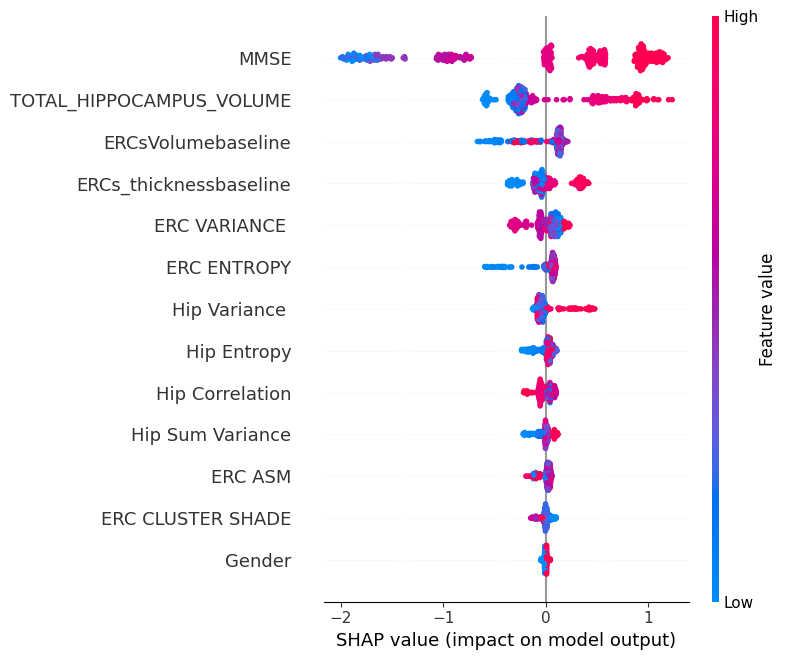

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


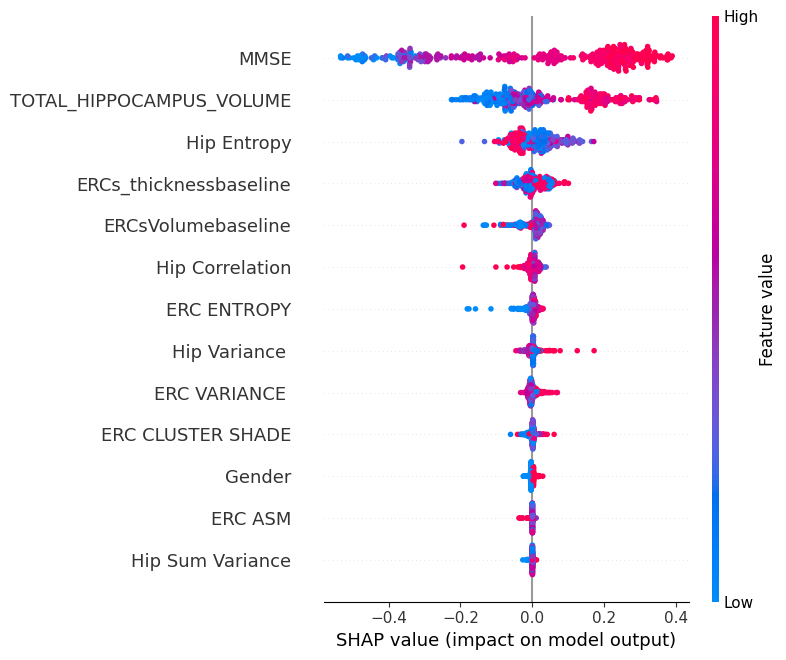

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


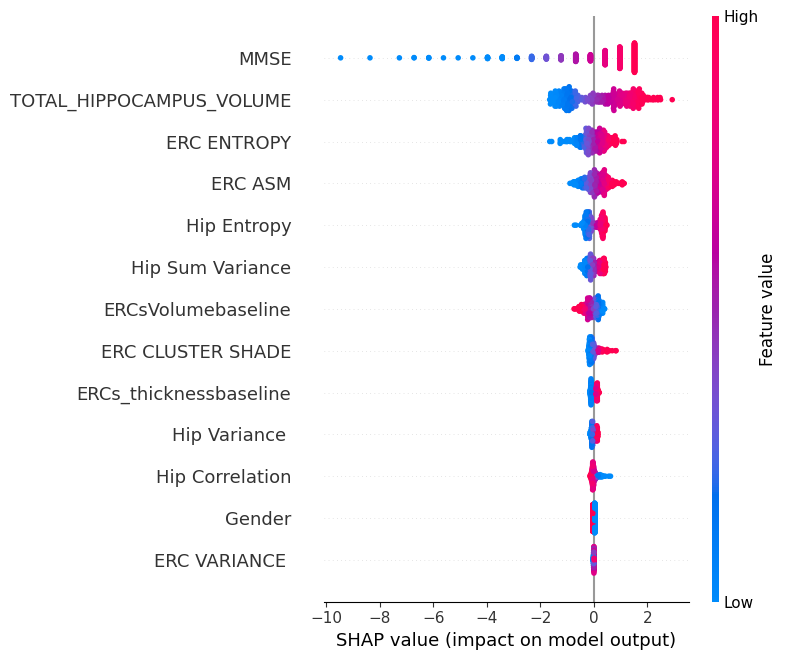

SHAP Beeswarm Plot for Class 1


C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


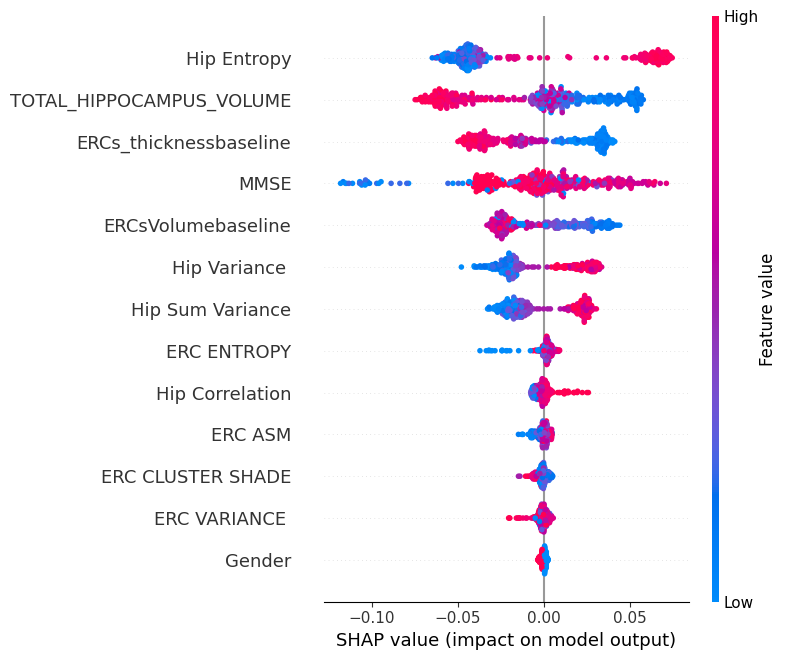

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


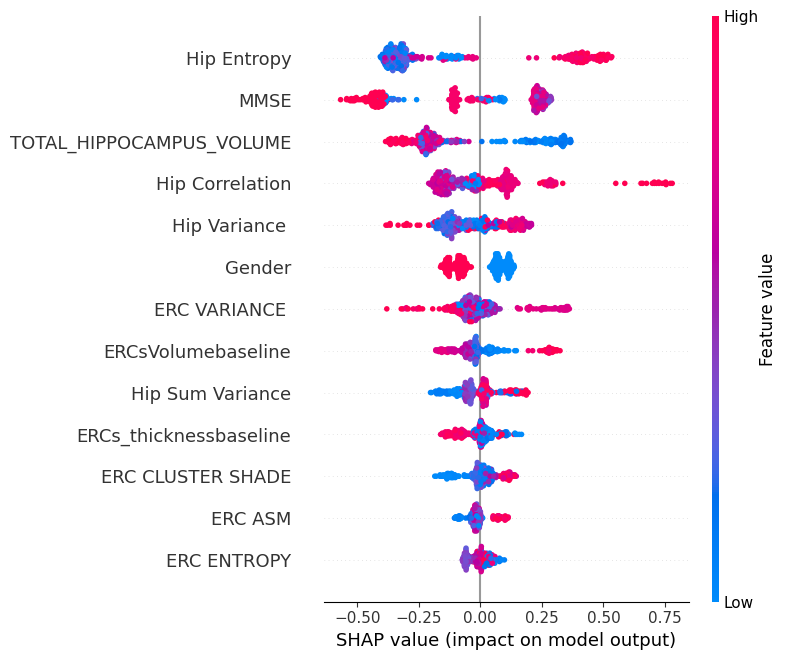

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


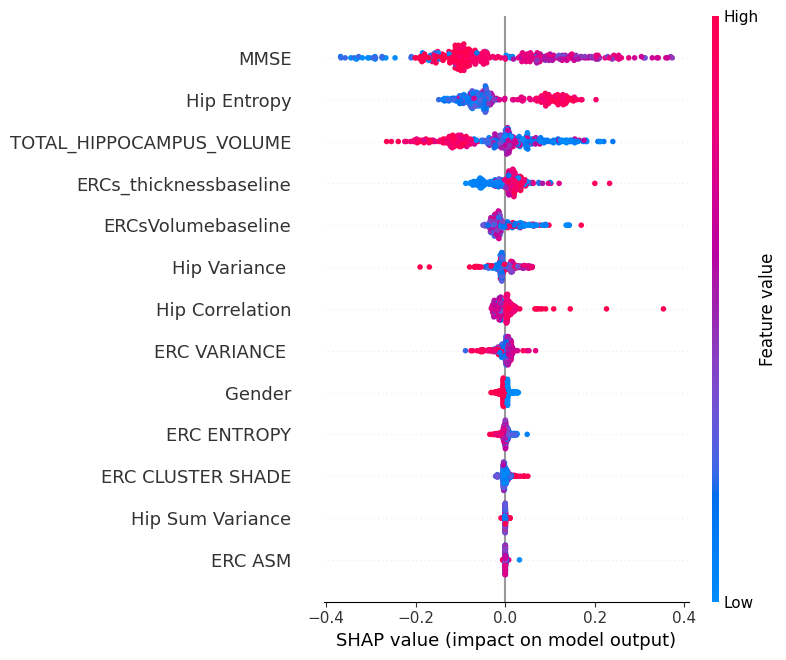

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


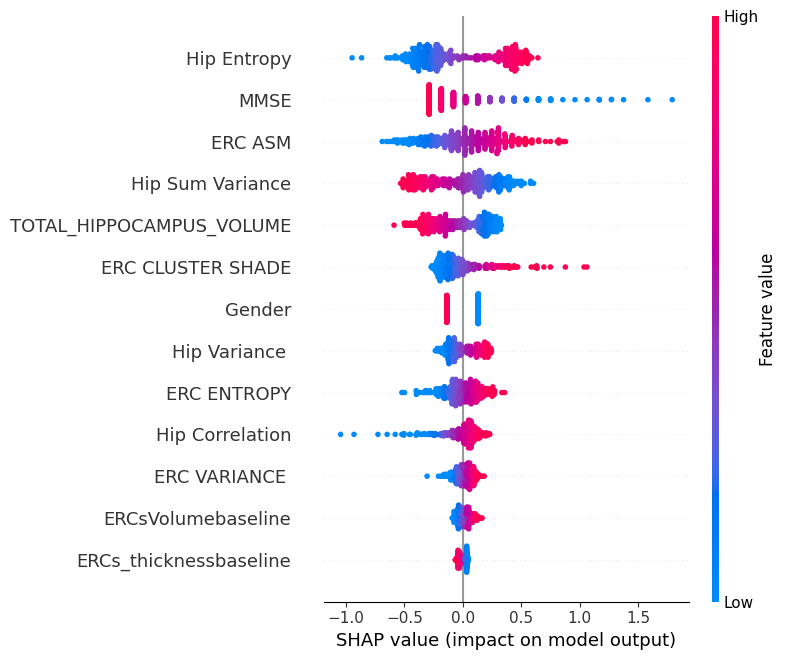

SHAP Beeswarm Plot for Class 2


C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


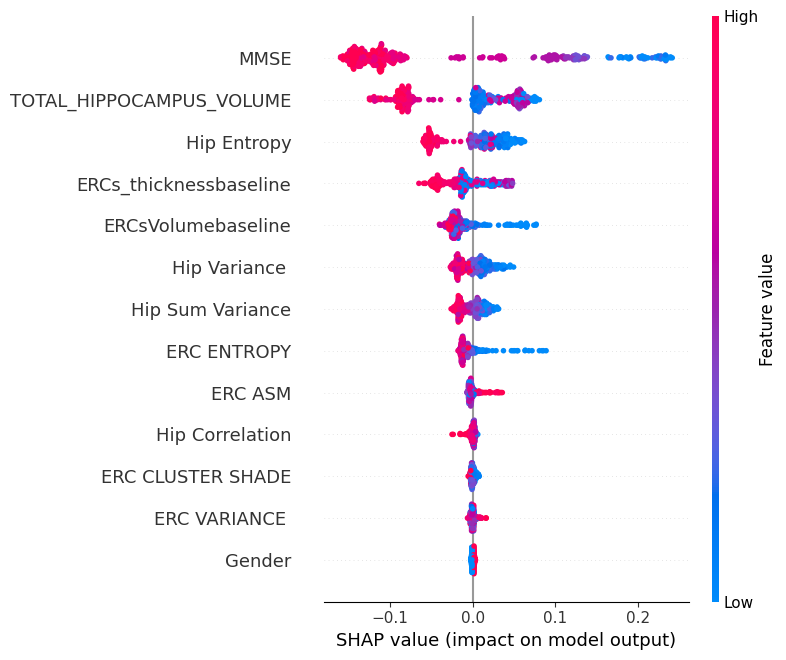

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


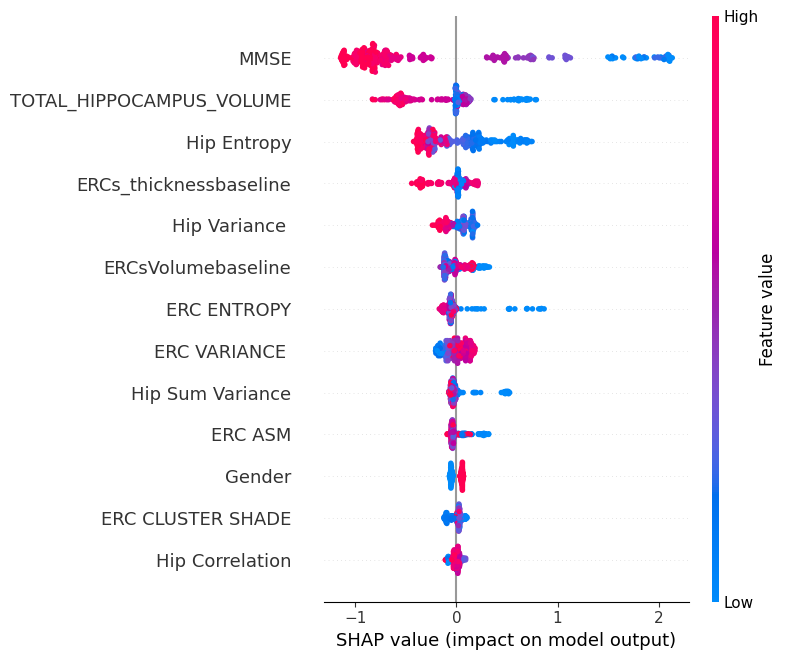

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


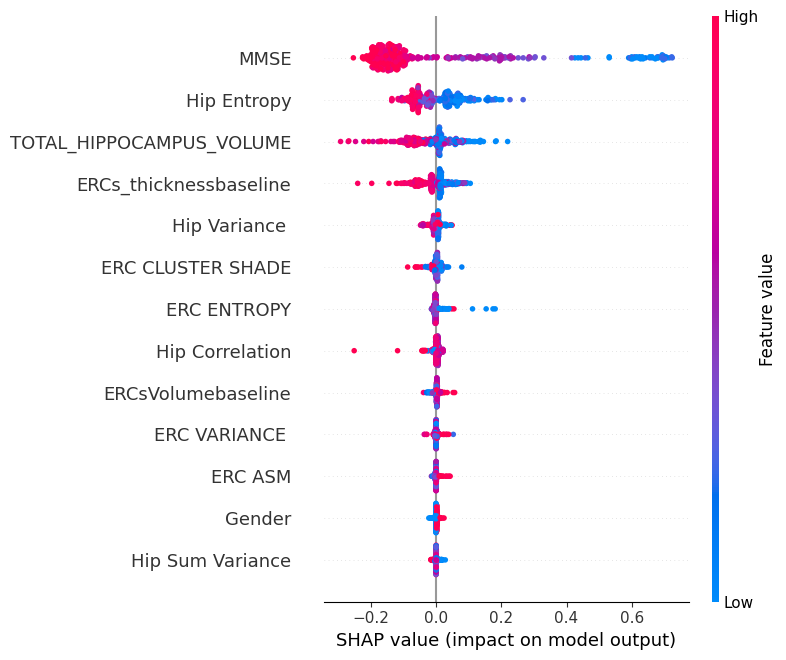

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\3528881374.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


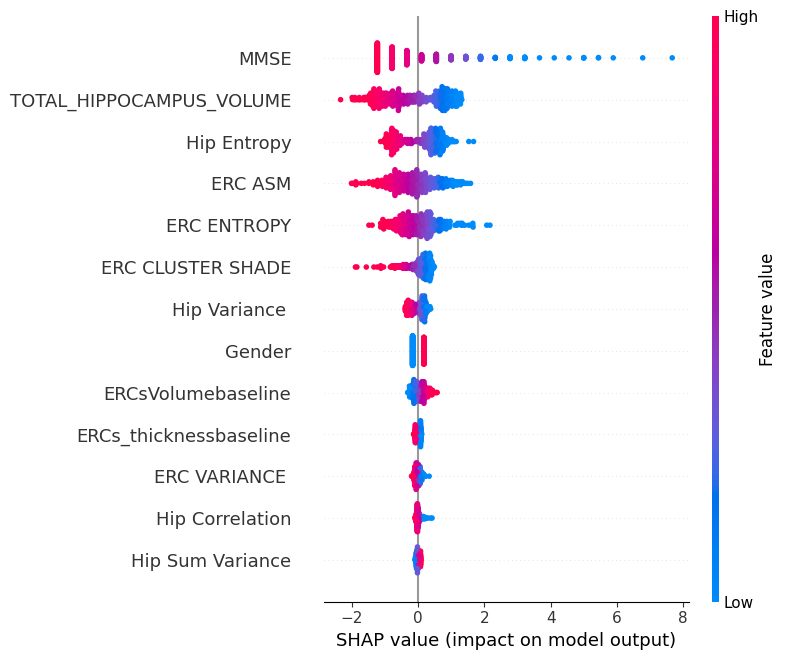

In [26]:
# Plot SHAP beeswarm for each class
for class_idx in range(shap_values_rf.shape[2]):  # Loop over each class
    print(f"SHAP Beeswarm Plot for Class {class_idx}")

    # Random Forest
    shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # XGBoost
    shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # NGBoost
    shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)
    
    # Logistic
    shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


C:\Users\steve\AppData\Local\Temp\ipykernel_2772\1301353166.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf_mean, X_test_t, feature_names=X_test_t.columns)


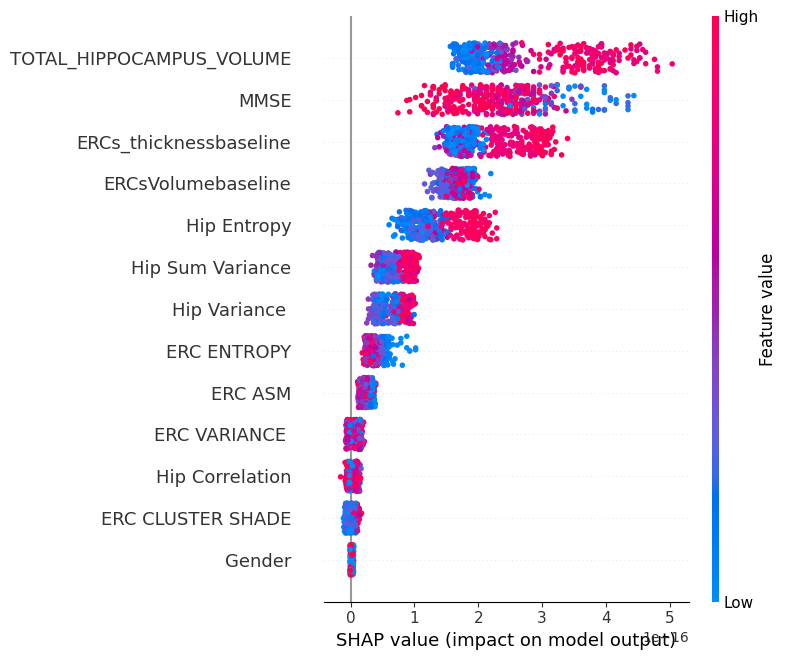

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\1301353166.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb_mean, X_test_t, feature_names=X_test_t.columns)


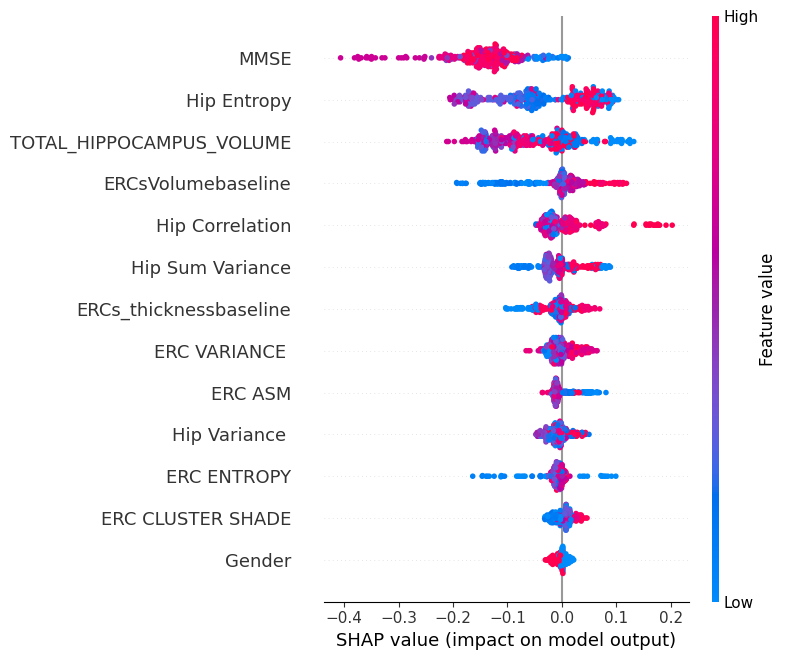

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\1301353166.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb_mean, X_test_t, feature_names=X_test_t.columns)


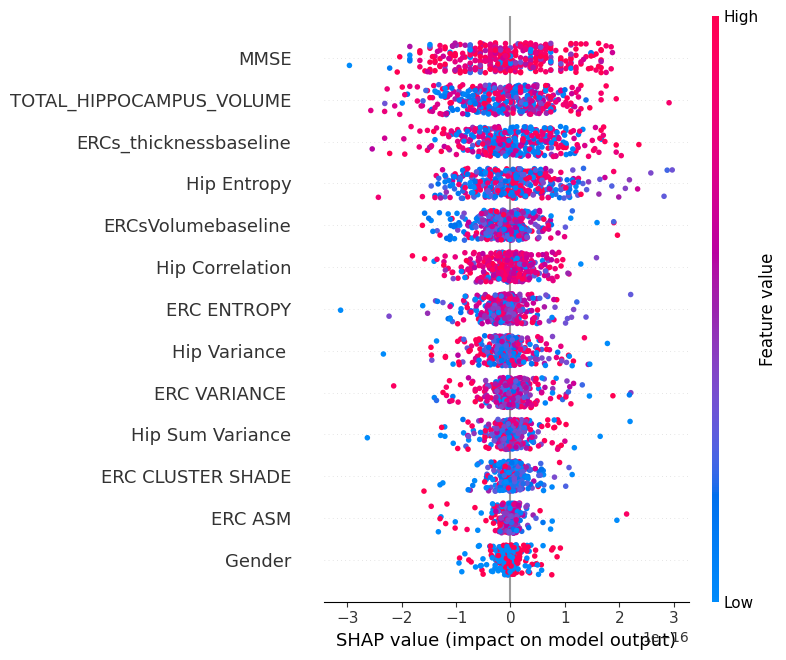

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\1301353166.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit_mean, X_test_t, feature_names=X_test_t.columns)


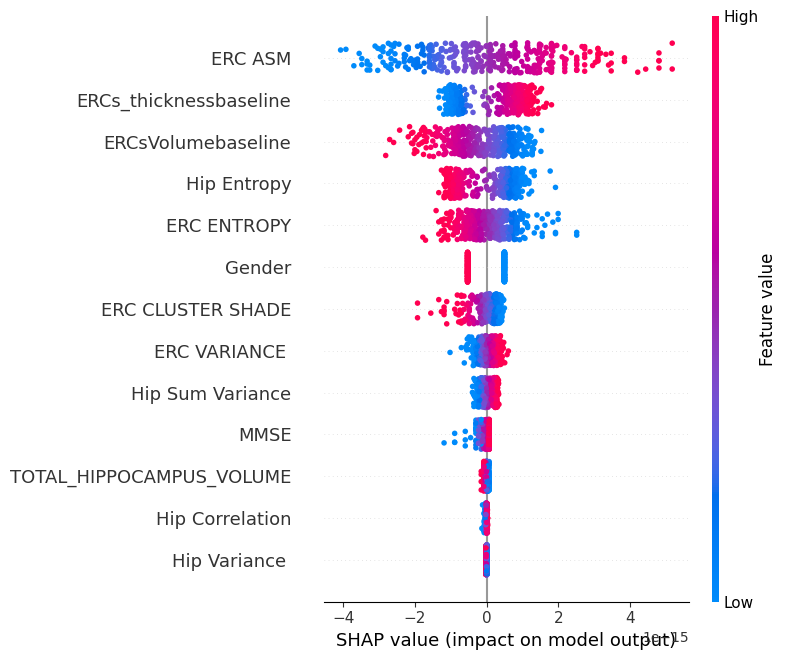

In [27]:
shap_values_rf_mean = shap_values_rf.mean(axis=2)  # Average over classes
shap_values_xgb_mean = shap_values_xgb.mean(axis=2)
shap_values_ngb_mean = shap_values_ngb.values.mean(axis=2)
shap_values_logit_mean = shap_values_logit.mean(axis=2)
# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_mean, X_test_t, feature_names=X_test_t.columns)


C:\Users\steve\AppData\Local\Temp\ipykernel_2772\903995680.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)


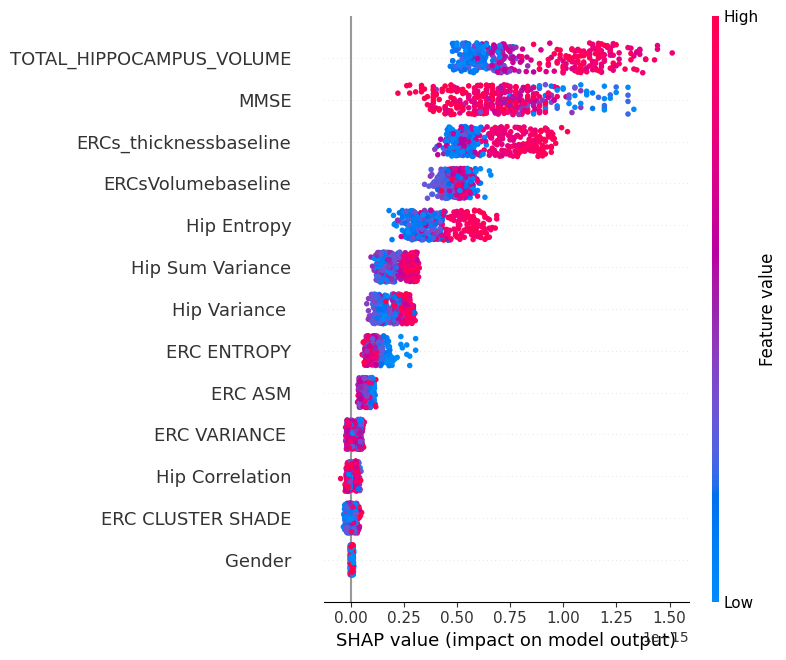

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\903995680.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)


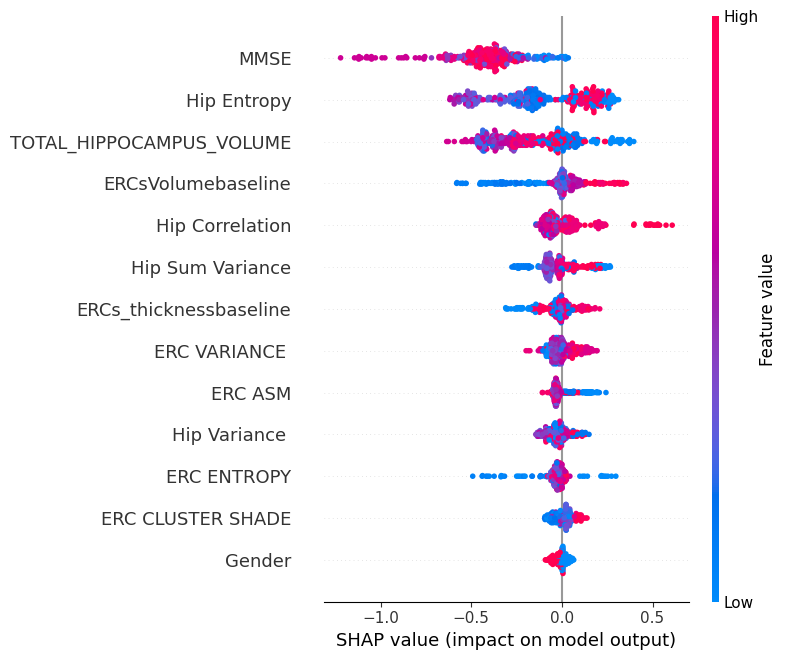

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\903995680.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)


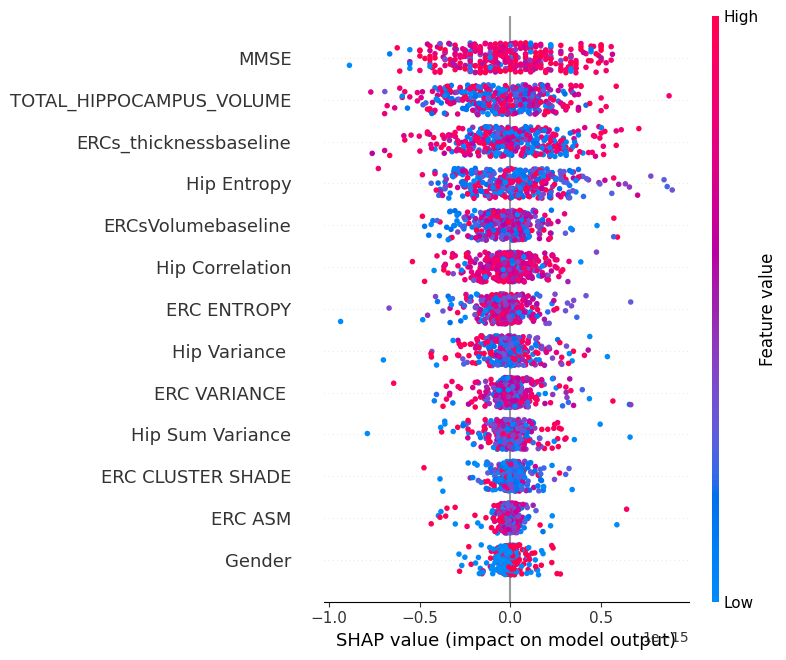

C:\Users\steve\AppData\Local\Temp\ipykernel_2772\903995680.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit_sum, X_test_t, feature_names=X_test_t.columns)


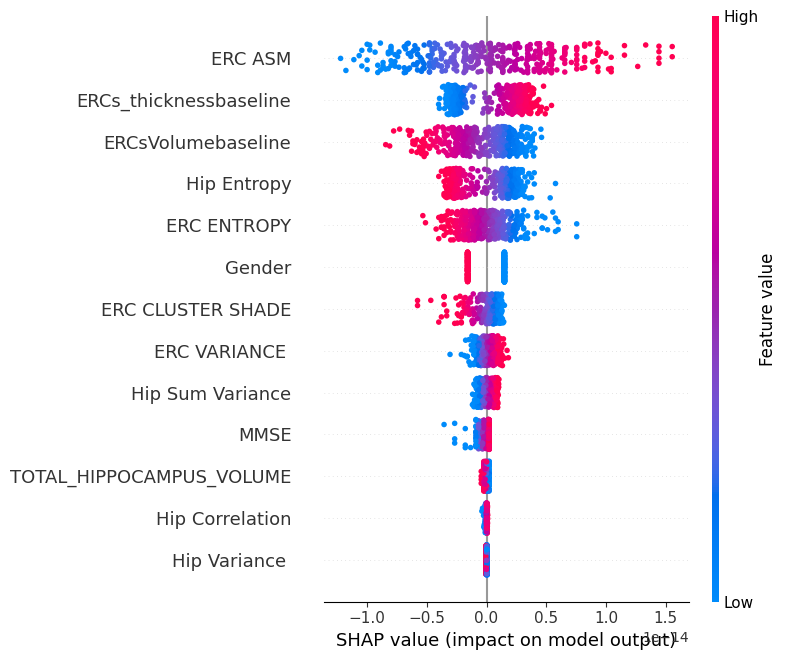

In [28]:
shap_values_rf_sum = shap_values_rf.sum(axis=2)  # Sum over classes
shap_values_xgb_sum = shap_values_xgb.sum(axis=2)
shap_values_ngb_sum = shap_values_ngb.values.sum(axis=2)
shap_values_logit_sum = shap_values_logit.sum(axis=2)

# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_sum, X_test_t, feature_names=X_test_t.columns)